# Техника сглаживания для тензорных норм (20 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (5 pts) Найдите аналитическую запись для градиента сглаженной версии целевого функционала $\|X\|_*$ используя в качестве прокс-функции $d(Z) = \frac{1}{2}\|Z\|_F^2$.
2. (5 pts) Реализуйте быстрый градиентный спуск (лекция про сглаживание или статья Smooth minimization of non-smooth functions [Nesterov, 2005]) для  сглаженной версии задачи RegMC problem. В качестве прокс-функции для прямой задачи используйте $d(Z) = \frac{1}{2}\|Z\|_F^2$.
3. (5 pts) Реализуйте какую-либо версию метода проксимального градиентного спуска для решения RegMC problem. 
4. (5 pts) Протестируйте алгоритмы из п.2-3 на тестовых данных. Для построния тестовых данных возьмите произвольный датасет картинок. Для каждой картинки удалите случайный набор пикселей (от 10% до 90%). 
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





За основу алгоритмов брал код отсюда. https://github.com/uprestel/Matrix-Completion/blob/antonio/Matrix-Completion.ipynb

# 1. Аналитическая запись градиента 

$$ f_{\mu}(X) = conj(f(x)) - \frac{\mu*||Y||_F^2}{2}, f(X) = ||X||_* $$

Найду dual для $||X||_*$. Пользуясь данным источником(https://math.stackexchange.com/questions/1158798/show-that-the-dual-norm-of-the-spectral-norm-is-the-nuclear-norm), получу $ ||X||_* = sup <X, Y>, ||Y||_2 \leq 1$.

Еще один источник, где показан тот же вывод(http://www.seas.ucla.edu/~vandenbe/236C/lectures/smoothing.pdf).

Тогда $ f_{\mu}(X) = sup_{||Y||_2 \leq 1} <X, Y> - \frac{\mu*||Y||_F^2}{2} $ 

Перепишу в одном виде, чтобы можно было выделить полный квадрат.

$ f_{\mu} (X) = min_{||Y||_2 \leq 1} \frac{\mu}{2}(Y, Y) - <X, Y> = min_{||Y||_2 \leq 1} \frac{\mu}{2}(Y - \frac{X}{\mu})^2 - \frac{X^2}{2\mu}$

Минимальное значение этого выражения достигается при $ Y = \frac{X}{\mu} $. Тогда условие $||Y||_2 \leq 1 $ перепишется в виде $ || \frac{X}{\mu} ||_2 = ||U(\frac{1}{\mu})SV|| = ||U(\frac{S}{\mu})V||\leq 1 $, $\sigma_{max}(\frac{X}{\mu})= \sigma_{max}(X) \leq \mu $.

По определению спеткральной нормы(второй), $ ||X||_2 = \sigma_{max}(X) $

Для другого же случая, когда $||Y||_2 > 1$, или, $\sigma_{max}(X) > \mu $, то минимальное значение будет достигаться на границе при $Y=1$.

То есть итоговый градиент имеет вид:

$$\nabla f_{\mu} (X) = \begin{cases}
  \frac{X}{\mu},  & \mbox{if } \sigma_{max}(X) \mbox{ $\leq \mu$} \\
  1, & \mbox{if } \sigma_{max}(X) \mbox{ $> \mu $}
\end{cases}$$

# Fast gradient

http://www.seas.ucla.edu/~vandenbe/publications/nucnrm.pdf(стр 3)

Буду пользоваться отсылкой на эту статью.

Another possibility is to replace the cost function with a smooth approximation and then minimize the smooth approximation by a fast gradient method. For example, a smooth approximation of the func $||X||_*$ is obtained by taking the SVD, $X = \sum_{i=1}^{r}\sigma_iu_iv_i^T$, replacing with singular values as

$$h_\mu(\sigma_i) = \begin{cases}
  \frac{\sigma_i^2}{2\mu},  & \mbox{if } \sigma_i \mbox{ $\leq \mu$} \\
  \sigma_i-\frac{\mu}{2}, & \mbox{if } \sigma_i \mbox{ $> \mu $}
\end{cases}$$

where $\mu$ is a small positive parameter, and defining $f_\mu(X) =  \sum_{i=1}^{r} h_{\mu}(\sigma_i)u_iv_i^T $. It can be shown that  $ f_{\mu}(X) = sup_{||Y||_2 \leq 1} tr(X^T Y) - \frac{\mu*||Y||_F^2}{2} $

Теперь запишу алгоритм быстрого градиентного спуска. Он встречается в статье Нестерова(https://core.ac.uk/download/pdf/191095369.pdf) под пунктом 3.11.

Сам алгоритм.

For $ k \geq 0 $ do

1. Compute$ f(x_k)$ and $\nabla f(x_k)$.
2. Find $ y_k = T_Q(x_k)$
3. Find $ z_k = agmin_x \{ \frac{L}{\sigma}d(x) + \sum_{i = 0}^k \frac{i+1}{2}[f(x_i) + <\nabla f(x_i), x - x_i>:x \in Q]$
4. Set $x_{k+1} = \frac{2}{k+3}z_k + \frac{k+1}{k+3}y_k $

Where $T_Q(X) \in Q$ the optimal solution of the following minimization problem:

$ min_y \{< \nabla  f(x), y - x> + \frac{1}{2} L ||y-x||^2: y \in Q \}$

In [267]:
import numpy as np
from numpy import tensordot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank as rank
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from PIL import Image
from numpy import asarray

In [268]:
path = "./chaplin.jpg"
image = Image.open(path).convert('L')
image = asarray(image)

In [429]:
def delete_pixels(image, p = 0.5):
    image = image.reshape(-1)
    dim = image.shape[0]
    random = np.random.choice(list(range(dim)), int((1-p)*dim), replace=False)
    return random, image[random]

In [430]:
index, y_true = delete_pixels(image)

In [398]:
def threshold(x, mu):
    if (mu >= x):
        return x/mu
    else:
        return 1
    
def grad1(X, mu):
    S, V, D = np.linalg.svd(X)
    ans = np.zeros(X.shape)
    for i in range(V.shape[0]):
        ans += threshold(V[i],mu)*np.tensordot(S[:,i].ravel(), D.T[:,i].ravel(), axes=((), ()))
    return ans

def update_true(X, ind, y):

    X1 = X.reshape(-1)
    X1[ind] = y
    return X1.reshape(X.shape)



In [415]:
def fast_grad(X, y_true, mu, n_iter, index):
    X = update_true(np.zeros(X.shape), index, y_true)
    np.zeros(X.shape[0]*X.shape[1])[index] = y_true
    iteratives = []
    gradient = np.zeros(X.shape)
    sum_grad = np.zeros(X.shape)
    for k in range(n_iter):
        gradient = grad1(X, mu)
        sum_grad +=  (k+1)/2*gradient
        y = X - 1/mu*gradient
        z = - mu*sum_grad
        X = 2/(k+3)*z + (k+1)/(k+3)*y
        iteratives.append(X)
        X = update_true(X, index, y_true) #поддерживание известных значений Xij = Yij
        
    return iteratives

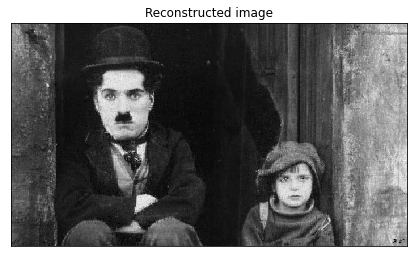

113.76097798347473


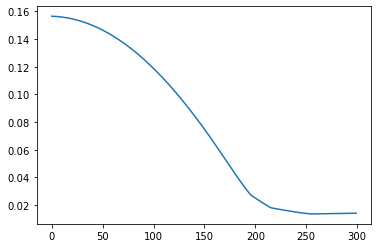

In [436]:
# ДЛя p = 0.5
import time
start = time.time()
n_iter = 300 
iteratives = fast_grad(image, y_true, mu = 1, n_iter = n_iter, index = index)

plot_image(iteratives[-1], title="Reconstructed image", newshape=(m, n))

losses = plot_L1_loss(image, iteratives)
plt.plot(np.arange(n_iter), losses)
print(time.time()-start)

# 3. Fast proximal gradient metrhod - FISTA

В статье нашел следующее. Тут напишу вывод статьи. Далее его реализую.


Тут на странице 9 приведен алгоритм FISTA.https://arxiv.org/pdf/1802.08397.pdf

Инициализация:

$R_1 = 0, t_1 = 1$
Обновление

for k = 1, 2, ..., T do

$$ 1. X_k = D(R_k - \frac{1}{L}A^*(A(R_k)-y))$$

$$ 2. t_{k+1} = \frac{1 + \sqrt{1+4t_k^2}}{2} $$

$$ 3. R_{k+1} = X_k + \frac{t_k-1}{t_k+1}(X_k - X_{k-1}) $$

Выход $X_T$

Искомая задача имеет вид:

$\hat{X} = argmin_{X} ||X||_*$,s.t $ y = A(X)$

$\hat{X} = argmin_X \frac{1}{2}||y- A(X)||_2^2 +\tau ||X||_* $

В пункте 1 алгоритма 1 нужно найти proximal mapping для целевой функции.

$D_\tau(Y) = argmin_Z \frac{1}{2}||Y-Z||_F^2 + \tau||Y||_* $

Если SVD матрицы $Y = U\Sigma V^T $, где $\Sigma = diag[\sigma_1, \sigma_2, ..]$, то $D_\tau(Y) = U\Sigma^{'}V^T$, где $\Sigma^{'} = diag[\sigma_1^{'}, \sigma_2^{'}, ..] $


$$\sigma^{'}_k = \begin{cases}
  \sigma_k - \tau,  & \mbox{if } \sigma_k \mbox{ $\geq \tau$} \\
  0, & \mbox{if } \sigma_k \mbox{ $< \tau $}
\end{cases}$$

In [26]:
def plot_image(vec, title="", xlabel="", ylabel="", shift=0, newshape=None, **kwargs): # вспомогательная ф-ция 

    if newshape is None:
        plt.matshow(vec[:,shift:], cmap="gray", **kwargs)
    else:
        plt.matshow(vec.reshape(newshape[0], newshape[1])[:,shift:], cmap="gray", **kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [291]:
def singular_value_shrinkage1(X, alpha, newshape):
    X_ = X.reshape(newshape[0], newshape[1])
    U, s, VT = np.linalg.svd(X_, full_matrices=True)
    sthres = np.maximum(s - alpha, 0)
    S = np.zeros_like(X_)
    np.fill_diagonal(S, sthres)
    X_out = U@S@VT
    return X_out.reshape(newshape[0] * newshape[1])

def FISTA(A, y_true, m, n, lambda_, n_iter):
    '''
    Input:
        A: matrix that encodes the known entries
        lambda_: threshold for the singular value shrinkage operator.'''
    
    
    iteratives = []
    X_kminus1 = np.zeros((m*n))
    Y_k = np.zeros((m*n))
    L=2
    t_k = 1
    lambda_ = lambda_/L

    for k in range(n_iter):
        
        w = Y_k - 1/L*(A.T@(A@Y_k - y_true)) # 1/L*grad
        X_k = singular_value_shrinkage1(w, lambda_, newshape=(m,n))
        t_kplus1 = (1 + np.sqrt(1+4*t_k**2))/2
        Y_k = X_k + ((t_k-1)/t_kplus1)*(X_k - X_kminus1)
        X_kminus1 = X_k
        t_k = t_kplus1  
        iteratives.append(Y_k)
    
    return iteratives
    


In [404]:
def plot_L1_loss(true_image, reconstructions): # отдельно функция для лосса

    m,n = true_image.shape

    iterations = np.arange(len(reconstructions))
    losses =[]
    for it in iterations:
        loss = 0.0
        current_rec = reconstructions[it].reshape(m, n)
        loss = np.linalg.norm(current_rec - true_image,1)/(m*n)

        losses.append(loss)

    return losses

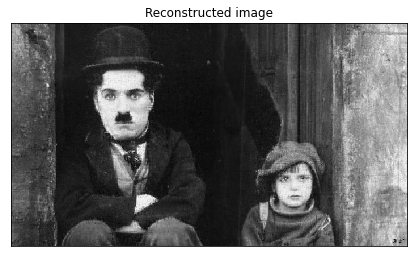

19.03476095199585


In [437]:
m, n = image.shape
#index, y_true = delete_pixels(image, p)
el = len(index) 
A = csc_matrix((np.ones(el), (np.arange(el), index)), shape=(el, m*n))
#матрица А хранит единичные индексы для каждого элемента маски
start = time.time()
recs = FISTA(A, y_true, m, n, lambda_=20, n_iter=300)

plot_image(recs[-1], title="Reconstructed image", newshape=(m, n))
print(time.time()-start)


Метод FISTA можно реализовать другим алгоритмом отсюда. Его не буду реализовывать.

$ min_X \frac{1}{2}|| P_{\Omega}(X) - P_{\Omega}(Y)|| + \beta||X||_* $



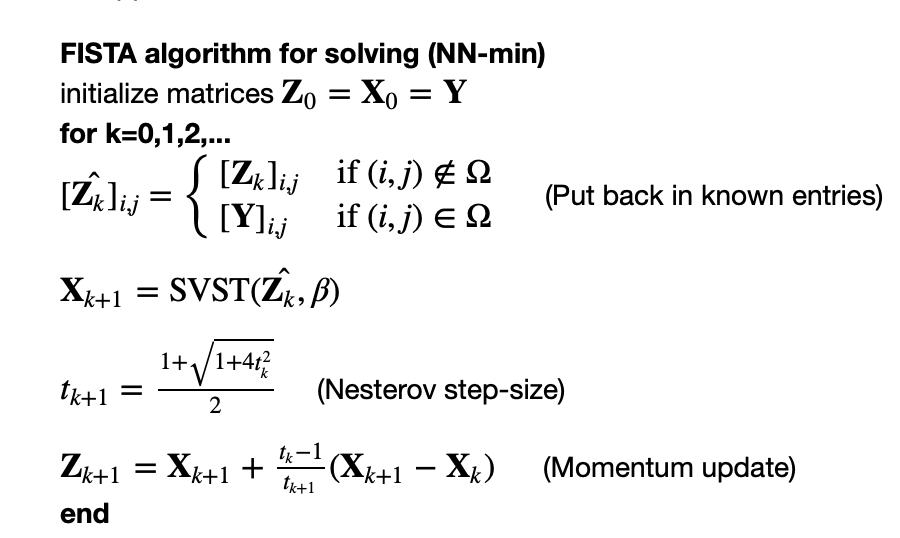

In [153]:
path="./Fista.png"
from IPython.display import Image
Image(filename = './Fista.png', width = 400, height = 200)

Где SVST - это такой же shrinkage threshold. С данным методом можно ознакомиться тут https://web.eecs.umich.edu/~fessler/course/551/julia/demo/09_lr_complete3.html

Статья, по которой делался метод, https://www.ceremade.dauphine.fr/~carlier/FISTA

Реализую еще один метод - DRS. Тут написана статья о нем. http://www.seas.ucla.edu/~vandenbe/236C/lectures/dr.pdf 

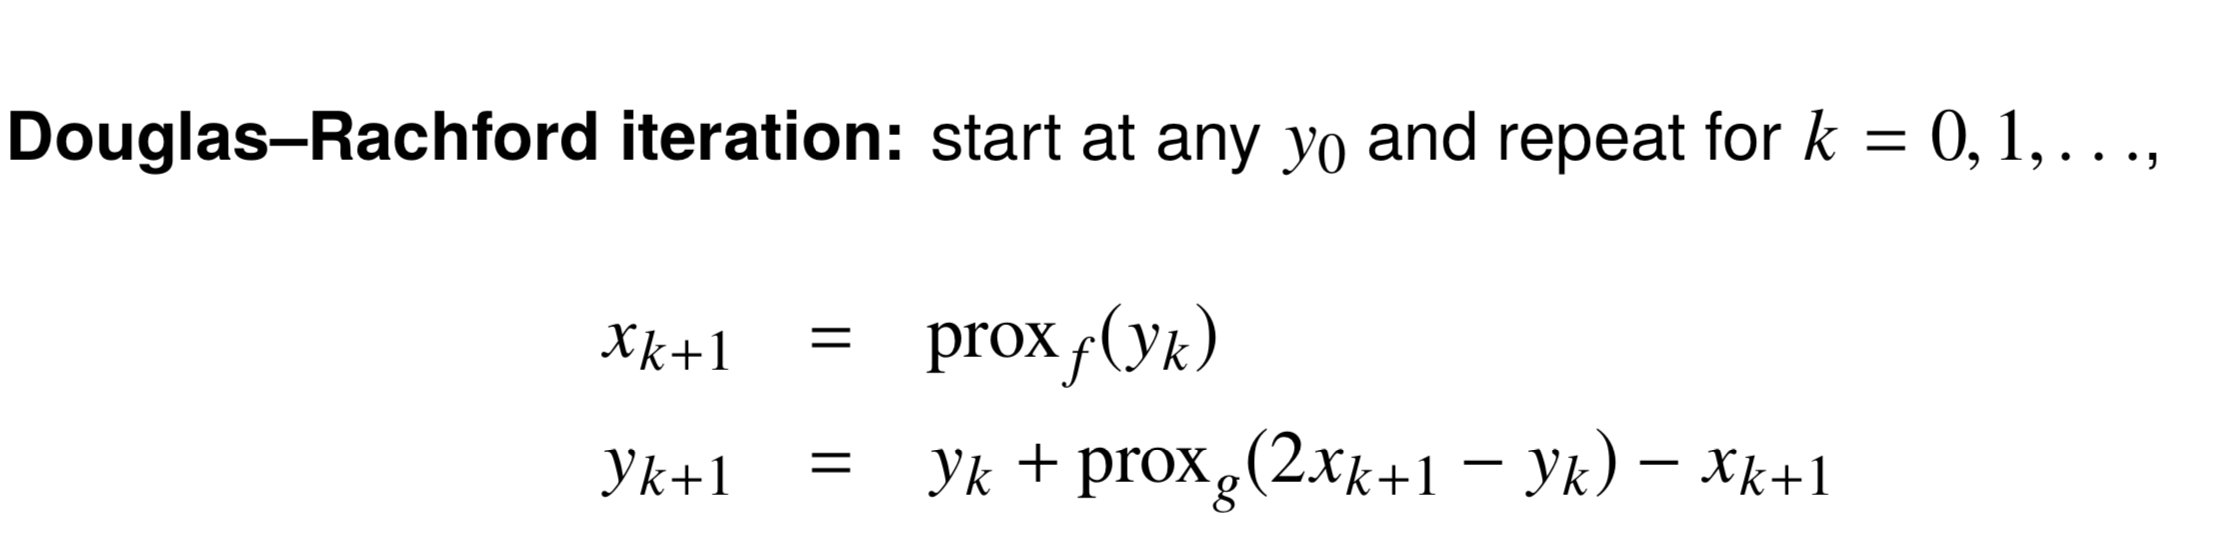

In [299]:
Image(filename = './DRS.png', width = 600, height = 300)

In [300]:
def DRS(A, y_true, m, n, iterations, gamma):
    
    iteratives = []
    zk = np.zeros(m*n)
    
    for k in range(0, iterations):
        xk = zk + A.T @ (y_true - A@zk)
        
        yk = singular_value_shrinkage1(2*xk - zk , gamma, newshape=(m,n))
        zk = zk + yk - xk
        iteratives.append(zk)
    
    return iteratives

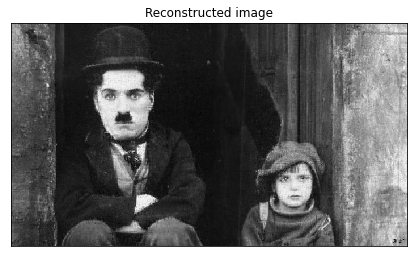

18.86962366104126


In [438]:
#index, y_true = delete_pixels(image, p =0.7)
el = len(index) 
A = csc_matrix((np.ones(el), (np.arange(el), index)), shape=(el, m*n))
#матрица А хранит единичные индексы для каждого элемента маски
start = time.time()
recs_DRS = DRS(A, y_true, m, n,iterations = 300, gamma = 20)

plot_image(recs[-1], title="Reconstructed image", newshape=(m, n))
print(time.time()-start)


# Анализ сходимости методов

In [439]:
losses = plot_L1_loss(image, recs)
losses_fast = plot_L1_loss(image, iteratives)
losses_DRS = plot_L1_loss(image, recs_DRS)

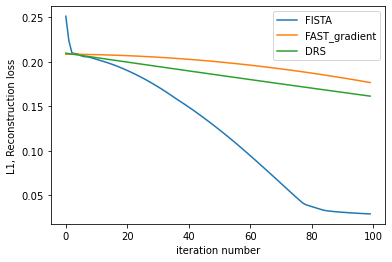

In [427]:
line_fista, = plt.plot(iterations,losses, label = 'FISTA')
line_fast, = plt.plot(iterations,losses_fast, label = 'FAST_gradient' )
line_DRS,  = plt.plot(iterations,losses_DRS, label = 'DRS' )
plt.xlabel("iteration number")
plt.ylabel("L1, Reconstruction loss")
plt.legend(handles=[line_fista, line_fast, line_DRS ])

Fista имеет более низкую ошибку через 100 итераций. Для p = 0.7.

Для p = 0.5 для 100 итераций

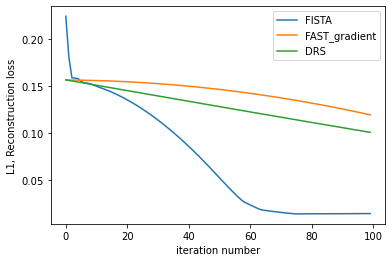

In [435]:
line_fista, = plt.plot(iterations,losses, label = 'FISTA')
line_fast, = plt.plot(iterations,losses_fast, label = 'FAST_gradient' )
line_DRS,  = plt.plot(iterations,losses_DRS, label = 'DRS' )
plt.xlabel("iteration number")
plt.ylabel("L1, Reconstruction loss")
plt.legend(handles=[line_fista, line_fast, line_DRS ])

Для p = 0.5 и 300 итераций

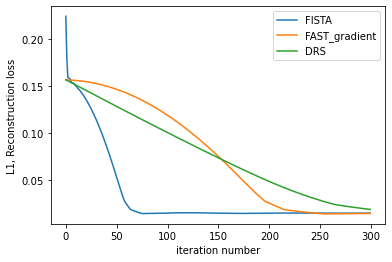

In [444]:
iterations = np.arange(300)
line_fista, = plt.plot(iterations,losses, label = 'FISTA')
line_fast, = plt.plot(iterations,losses_fast, label = 'FAST_gradient' )
line_DRS,  = plt.plot(iterations,losses_DRS, label = 'DRS' )
plt.xlabel("iteration number")
plt.ylabel("L1, Reconstruction loss")
plt.legend(handles=[line_fista, line_fast, line_DRS ])

Видно, то все алгоритмы при n = 300 сходятся
Но Fista гораздо быстрее сходится, чем остальные. 
Fast gradient же сначала хуже DRS, потом его обгоняет по качеству.
Также хотел бы отметить, что FISTA при хорошем качесте, работает быстро.

При n = 300, p =0.5 время работы:
FISTA: 19.34 сек
DRS: 18.36 сек
FAST-grad: 113.3 сек

ИТОГО: Лучше всего работает FISTA